In [ ]:
############################################################# IMPORTING LIBRARIES #######################################################################
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting
from scipy.optimize import minimize_scalar  # For scalar minimization functions
from functools import partial  # For creating partially evaluated functions
from scipy.optimize import minimize  # For general optimization
from sympy import symbols  # For symbolic math
from sympy import init_printing  # For pretty printing in symbolic math
import math
from IPython.core.display import Image, display
from matplotlib import rc
from matplotlib import rc
from matplotlib import colors
import math
from functools import partial
%matplotlib inline
rc('text', usetex=True)
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc ('axes', labelsize=12)

In [ ]:
#Latex installation
! sudo apt-get install texlive-latex-recommended
! sudo apt install texlive-latex-extra
! sudo apt install dvipng
!sudo apt install cm-super

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-urw-base35
  libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6
  libptexenc1 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data t1utils tex-common texlive-base
  texlive-binaries texlive-latex-base xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  poppler-utils ghostscript fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum debhelper gv | postscript-viewer perl-tk xpdf
  | pdf-viewer xzdec texlive-latex-base-doc texlive-latex-recommended-doc
  texlive-luatex texlive-pstricks
The following NEW packages will be installed:
  dvisvgm fonts-droid-fallback fonts

In [ ]:
# Given constants
gamma = 0.2  # dB/km
epsilon_0 = 0.01
upsilon_el = 0.1
eta_D = 0.5
f = 0.95

In [ ]:
def G(x):
    if x > 0:
        return (x + 1) * np.log2(x + 1) - x * np.log2(x)
    elif x == 0:
        return 0
    else:
        return float('-inf')


def secure_key_rateA(VA,L,n0):
    T = 10 ** (-gamma * L / 10)
    e_A = 2 * VA * (1 + upsilon_el - (eta_D) / 2) / (n0 * eta_D)
    V = VA + 1
    epsilon_E = epsilon_0 + e_A
    chi_het = (1 + (1 - eta_D) + 2 * upsilon_el) / eta_D
    chi_line = (1 / T) - 1 + epsilon_E
    chi_tot = chi_line + chi_het / T

    # Ensure positive inputs for np.log2
    if V + chi_tot <= 0 or 1 + chi_tot <= 0:
        return float('-inf')

    I_AB = np.log2((V + chi_tot) / (1 + chi_tot))

    A = V**2 * (1 - 2*T) + 2*T + T**2 * (V + chi_line)**2
    B = T**2 * (V * chi_line + 1)**2

    A2_minus_4B = A**2 - 4 * B
    #Ensure non-negative input for np.sqrt
    if A2_minus_4B < 0:
        return float('-inf')

    lambda_1 = np.sqrt(0.5 * (A + np.sqrt(A2_minus_4B)))
    lambda_2 = np.sqrt(0.5 * (A - np.sqrt(A2_minus_4B)))
    C = (1 / (T * (V + chi_tot)))**2 * (A * chi_het**2 + B + 1 + 2 * chi_het * (V * np.sqrt(B) + T * (V + chi_line)) + 2 * T * (V**2 - 1))
    D = ((V + np.sqrt(B) * chi_het) / (T * (V + chi_tot)))**2
    C2_minus_4D = C**2 - 4 * D

    # Ensure non-negative input for np.sqrt
    if C2_minus_4D < 0:
        return float('-inf')
    lambda_3 = np.sqrt(0.5 * (C + np.sqrt(C2_minus_4D)))
    lambda_4 = np.sqrt(0.5 * (C - np.sqrt(C2_minus_4D)))
    lambda_5 = 1

    #G = lambda x: (x + 1) * np.log2(x + 1) - x * np.log2(x) if x >= 0 else float('-inf')
    #G = lambda x: (x + 1) * np.log2(x + 1) - x * np.log2(x)
    # Ensure valid values for G function inputs
    g1 = G((lambda_1 - 1)/2)
    g2 = G((lambda_2 - 1)/2)
    g3 = G((lambda_3 - 1)/2)
    g4 = G((lambda_4 - 1)/2)
    g5 = G((lambda_5 - 1)/2)

    #G = lambda x: (x + 1) * np.log2(x + 1) - x * np.log2(x)

    #chi_BE = G(lambda_1 - 0.5) + G(lambda_2 - 0.5) - G(lambda_3 - 0.5) - G(lambda_4 - 0.5) -G(lambda_5)

    if g1 == float('-inf') or g2 == float('-inf') or g3 == float('-inf') or g4 == float('-inf') or g5 == float('-inf'):
        return float('-inf')

    chi_BE = g1 + g2 - g3 - g4 - g5

    if np.isnan(chi_BE):
        return float('-inf')

    R = f * I_AB - chi_BE



    return -R


In [ ]:
def secure_key_rate(VA,L,n0):
    T = 10 ** (-gamma * L / 10)
    e_A = 2 * VA * (1 + upsilon_el - (eta_D) / 2) / (n0 * eta_D)
    V = VA + 1
    epsilon_E = epsilon_0 + e_A
    chi_het = (1 + (1 - eta_D) + 2 * upsilon_el) / eta_D
    chi_line = (1 / T) - 1 + epsilon_E
    chi_tot = chi_line + chi_het / T

    # Ensure positive inputs for np.log2
    if V + chi_tot <= 0 or 1 + chi_tot <= 0:
        return float('-inf')

    I_AB = np.log2((V + chi_tot) / (1 + chi_tot))

    A = V**2 * (1 - 2*T) + 2*T + T**2 * (V + chi_line)**2
    B = T**2 * (V * chi_line + 1)**2

    A2_minus_4B = A**2 - 4 * B
    # Ensure non-negative input for np.sqrt
    if A2_minus_4B < 0:
        return float('-inf')

    lambda_1 =np.sqrt(0.5 * (A + np.sqrt(A2_minus_4B)))
    lambda_2 = np.sqrt(0.5 * (A - np.sqrt(A2_minus_4B)))
    C = (1 / (T * (V + chi_tot)))**2 * (A * chi_het**2 + B + 1 + 2 * chi_het * (V * np.sqrt(B) + T * (V + chi_line)) + 2 * T * (V**2 - 1))
    D = ((V + np.sqrt(B) * chi_het) / (T * (V + chi_tot)))**2
    C2_minus_4D = C**2 - 4 * D

    # Ensure non-negative input for np.sqrt
    if C2_minus_4D < 0:
        return float('-inf')
    lambda_3 = np.sqrt(0.5 * (C + np.sqrt(C2_minus_4D)))
    lambda_4 = np.sqrt(0.5 * (C - np.sqrt(C2_minus_4D)))
    lambda_5 = 1

    #G = lambda x: (x + 1) * np.log2(x + 1) - x * np.log2(x) if x >= 0 else float('-inf')

    # Ensure valid values for G function inputs
    g1 = G((lambda_1 - 1)/2)
    g2 = G((lambda_2 - 1)/2)
    g3 = G((lambda_3 - 1)/2)
    g4 = G((lambda_4 - 1)/2)
    g5 = G((lambda_5 - 1)/2)

    if g1 == float('-inf') or g2 == float('-inf') or g3 == float('-inf') or g4 == float('-inf') or g5 == float('-inf'):
        return float('-inf')

    chi_BE = g1 + g2 - g3 - g4 - g5

    if np.isnan(chi_BE):
        return float('-inf')


    R = f * I_AB - chi_BE


    return R


In [ ]:
def objective(VA,L,n0):
    R = -secure_key_rate(VA,L,n0)
    return R

In [ ]:
def optimal_va(L,n0):
    VA_bounds = (0.1, 10)
    result = minimize_scalar(lambda VA: objective(VA, L, n0),
                             bounds=VA_bounds, method='bounded')
    VA_opt = result.x
    return VA_opt

In [ ]:
def optkeyrate(L, n0):
    # Find the optimal VA
    VA_opt = optimal_va(L, n0)
    # Calculate the maximum key rate at this VA
    R_max = secure_key_rate(VA_opt, L, n0)

    return R_max

In [ ]:
L_values = np.linspace(0.1, 200, 500)
keylist50=[]
keylist100=[]
keylist500=[]
for L in L_values:
  ans50=optkeyrate(L, 50)
  ans100=optkeyrate(L, 100)
  ans500=optkeyrate(L, 500)
  keylist50.append(ans50)
  keylist100.append(ans100)
  keylist500.append(ans500)

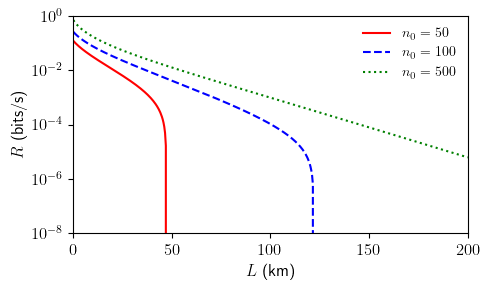

In [ ]:
# Create a single plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Plot each key list
ax.plot(L_values, keylist50, color="red", ls='-', label=r'$n_0=50$')
ax.plot(L_values, keylist100, color="blue", ls='--', label=r'$n_0=100$')
ax.plot(L_values, keylist500, color="green", ls=':', label=r'$n_0=500$')

# Set log scale for y-axis
ax.set_yscale('log')

# Labels and ticks
ax.set_xlabel(r'$L$ (km)', fontsize=12)
ax.set_ylabel(r'$R$ (bits/s)', fontsize=12)
ax.set_xlim(0, 200)
ax.set_ylim(1e-8, 1e0)

# Legend
ax.legend(fontsize=10, loc='upper right', frameon=False)

# Layout adjustment
fig.tight_layout()

# Save the figure if needed
plt.savefig('fig2.pdf', format='pdf', bbox_inches='tight', dpi=600)

plt.show()


In [ ]:
import numpy as np

Lnew_values = np.linspace(0.1, 200, 200)

keylist2d_50_opt = []
keylist2d_100_opt = []
keylist2d_500_opt = []

result50_opt = np.zeros(len(Lnew_values))
result100_opt = np.zeros(len(Lnew_values))
result500_opt = np.zeros(len(Lnew_values))

for i, Lnew in enumerate(Lnew_values):
    VA_opt_50 = optimal_va(Lnew, 50)
    VA_opt_100 = optimal_va(Lnew, 100)
    VA_opt_500 = optimal_va(Lnew, 500)

    # Evaluate key rate at the optimized VA
    result50_opt[i] = secure_key_rate(VA_opt_50, Lnew, 50)
    result100_opt[i] = secure_key_rate(VA_opt_100, Lnew, 100)
    result500_opt[i] = secure_key_rate(VA_opt_500, Lnew, 500)

keylist2d_50_opt.append(result50_opt)
keylist2d_100_opt.append(result100_opt)
keylist2d_500_opt.append(result500_opt)


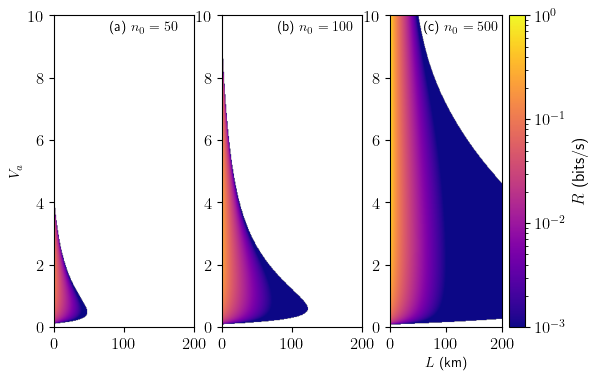

In [ ]:
# Define VA range for 2D plot
VA_values = np.linspace(1e-5, 10, 500)

# Initialize 2D arrays for each n0
krlist2d_50 = np.zeros((len(VA_values), len(Lnew_values)))
krlist2d_100 = np.zeros((len(VA_values), len(Lnew_values)))
krlist2d_500 = np.zeros((len(VA_values), len(Lnew_values)))

# Fill the 2D arrays
for i, VA in enumerate(VA_values):
    for j, L in enumerate(Lnew_values):
        krlist2d_50[i, j] = secure_key_rate(VA, L, 50)
        krlist2d_100[i, j] = secure_key_rate(VA, L, 100)
        krlist2d_500[i, j] = secure_key_rate(VA, L, 500)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(6.150, 4.05), sharex=True)

cmapp = 'plasma'

# n0 = 50
im0 = axs[0].imshow(krlist2d_50, aspect='auto',
                    extent=[Lnew_values.min(), Lnew_values.max(), VA_values.min(), VA_values.max()],
                    origin='lower', cmap=cmapp, norm=colors.LogNorm(vmin=0.001, vmax=1))
#fig.colorbar(im0, ax=axs[0], label=r'$R$ (bits/s)')
axs[0].set_ylim(0,10)
axs[0].set_xlim(0,50)
#axs[0].set_xticks(0,50,100,150,200)
axs[0].set_ylabel(r'$V_a$', fontsize=10)
axs[0].text(80, 9.5, r'(a)~$n_0=50$', fontsize=10)

# n0 = 100
im1 = axs[1].imshow(krlist2d_100, aspect='auto',
                    extent=[Lnew_values.min(), Lnew_values.max(), VA_values.min(), VA_values.max()],
                    origin='lower', cmap=cmapp, norm=colors.LogNorm(vmin=0.001, vmax=1))
#fig.colorbar(im1, ax=axs[1], label=r'$R$ (bits/s)')
axs[1].set_ylim(0,10)
axs[1].set_xlim(0,120)
#axs[1].set_ylabel(r'$V_a$', fontsize=10)
axs[1].text(80, 9.5, r'(b)~$n_0=100$', fontsize=10)

# n0 = 500
im2 = axs[2].imshow(krlist2d_500, aspect='auto',
                    extent=[Lnew_values.min(), Lnew_values.max(), VA_values.min(), VA_values.max()],
                    origin='lower', cmap=cmapp, norm=colors.LogNorm(vmin=0.001, vmax=1))
fig.colorbar(im2, ax=axs[2], label=r'$R$ (bits/s)')
axs[2].set_ylim(0,10)
axs[2].set_xlim(0,200)
#axs[2].set_ylabel(r'$V_a$', fontsize=10)
axs[2].set_xlabel(r'$L$ (km)', fontsize=10)
axs[2].text(60, 9.5, r'(c)~$n_0=500$', fontsize=10)

# Layout adjustments
#fig.tight_layout()
#fig.subplots_adjust(hspace=0.25)

# Save figure
plt.savefig('fig1.pdf', format='pdf', bbox_inches='tight', pad_inches=0.02, dpi=600)
plt.show()


In [ ]:
def holevo_bound(VA, L, n0):
    T = 10 ** (-gamma * L / 10)
    e_A = 2 * VA * (1 + upsilon_el - (eta_D) / 2) / (n0 * eta_D)
    V = VA + 1
    epsilon_E = epsilon_0 + e_A
    chi_het = (1 + (1 - eta_D) + 2 * upsilon_el) / eta_D
    chi_line = (1 / T) - 1 + epsilon_E
    chi_tot = chi_line + chi_het / T
    A = V**2 * (1 - 2*T) + 2*T + T**2 * (V + chi_line)**2
    B = T**2 * (V * chi_line + 1)**2

    A2_minus_4B = A**2 - 4 * B
    #Ensure non-negative input for np.sqrt
    if A2_minus_4B < 0:
        return float('-inf')

    lambda_1 = np.sqrt(0.5 * (A + np.sqrt(A2_minus_4B)))
    lambda_2 = np.sqrt(0.5 * (A - np.sqrt(A2_minus_4B)))
    C = (1 / (T * (V + chi_tot)))**2 * (A * chi_het**2 + B + 1 + 2 * chi_het * (V * np.sqrt(B) + T * (V + chi_line)) + 2 * T * (V**2 - 1))
    D = ((V + np.sqrt(B) * chi_het) / (T * (V + chi_tot)))**2
    C2_minus_4D = C**2 - 4 * D

    # Ensure non-negative input for np.sqrt
    if C2_minus_4D < 0:
        return float('-inf')
    lambda_3 = np.sqrt(0.5 * (C + np.sqrt(C2_minus_4D)))
    lambda_4 = np.sqrt(0.5 * (C - np.sqrt(C2_minus_4D)))
    lambda_5 = 1

    #G = lambda x: (x + 1) * np.log2(x + 1) - x * np.log2(x) if x >= 0 else float('-inf')
    #G = lambda x: (x + 1) * np.log2(x + 1) - x * np.log2(x)
    # Ensure valid values for G function inputs
    g1 = G((lambda_1 - 1)/2)
    g2 = G((lambda_2 - 1)/2)
    g3 = G((lambda_3 - 1)/2)
    g4 = G((lambda_4 - 1)/2)
    g5 = G((lambda_5 - 1)/2)

    #G = lambda x: (x + 1) * np.log2(x + 1) - x * np.log2(x)

    #chi_BE = G(lambda_1 - 0.5) + G(lambda_2 - 0.5) - G(lambda_3 - 0.5) - G(lambda_4 - 0.5) -G(lambda_5)

    if g1 == float('-inf') or g2 == float('-inf') or g3 == float('-inf') or g4 == float('-inf') or g5 == float('-inf'):
        return float('-inf')

    chi_BE = g1 + g2 - g3 - g4 - g5

    if np.isnan(chi_BE):
        return float('-inf')
    return chi_BE


In [ ]:
def objective_hol(VA,L,n0):
    return -holevo_bound(VA[0], L, n0)

In [ ]:
def opt_holevo_bound(L, n0):
    # Bounds for the SNR search. SNR must be non-negative.
    VA_bounds = (0.1, 10)

    # Use a safe initial guess for SNR
    initial_guess_VA = [1.0]

    # Perform the minimization to find the optimal SNR
    result = minimize(objective_hol, x0=initial_guess_VA, args=(L, n0),
                      bounds=[VA_bounds], method='L-BFGS-B')

    # Extract the optimal SNR from the minimization result
    optimal_VA = result.x[0]

    # Calculate the Holevo bound with the optimal SNR
    optimal_holevo = holevo_bound(optimal_VA, L, n0)

    return optimal_holevo


In [ ]:
n0_values = np.linspace(1e-5, 500, 200)

# Initialize lists
hollistd40 = []

# Fill the lists
for n0 in n0_values:
    hollistd40.append(opt_holevo_bound(40, n0))

# Convert to numpy arrays (optional)
#hollistd10 = np.array(hollistd10)
#hollistd40 = np.array(hollistd40)
#hollistd60 = np.array(hollistd60)
#hollistd80 = np.array(hollistd80)
#hollistd100 = np.array(hollistd100)

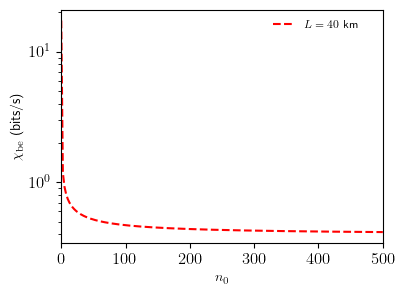

In [ ]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(4.150, 3.05))
ax.plot(n0_values, hollistd40, color="red", ls='--', label=r'$L=40$ km')
ax.set_xlabel(r'$n_0$', fontsize=10)
ax.set_ylabel(r'$\chi_{\mathrm{be}}$ (bits/s)', fontsize=10)
#ax.set_xscale('log')
ax.set_xlim(0,500)
#ax.set_ylim(0,10)
ax.set_yscale('log')

ax.legend(loc='upper right', fontsize=8, frameon=False, bbox_to_anchor=(0.955, 1))

fig.tight_layout()
plt.savefig('Fig_Holevo_vs_n0.pdf', format='pdf', bbox_inches='tight', pad_inches=0.02, dpi=600)
plt.show()


In [ ]:
def mutual_info(VA,L,n0):
    T = 10 ** (-gamma * L / 10)
    e_A = 2 * VA * (1 + upsilon_el - (eta_D) / 2) / (n0 * eta_D)
    V = VA + 1
    epsilon_E = epsilon_0 + e_A
    chi_het = (1 + (1 - eta_D) + 2 * upsilon_el) / eta_D
    chi_line = (1 / T) - 1 + epsilon_E
    chi_tot = chi_line + chi_het / T

    # Ensure positive inputs for np.log2
    if V + chi_tot <= 0 or 1 + chi_tot <= 0:
        return float('-inf')

    I_AB = np.log2((V + chi_tot) / (1 + chi_tot))
    return I_AB


In [ ]:
def objective_mut(VA,L,n0):
    I_AB = -mutual_info(VA[0], L, n0)
    return I_AB

In [ ]:
def opt_mutual_info(L,n0):
    VA_bounds = (0.1, 10)

    # Use a safe initial guess for SNR
    initial_guess_VA = [1.0]

    # Perform the minimization to find the optimal SNR
    result = minimize(objective_mut, x0=initial_guess_VA, args=(L, n0),
                      bounds=[VA_bounds], method='L-BFGS-B')

    # Extract the optimal SNR from the minimization result
    optimal_VA = result.x[0]

    # Calculate the Holevo bound with the optimal SNR
    optimal_mut = mutual_info(optimal_VA, L, n0)

    return optimal_mut


In [ ]:
n0_values = np.linspace(1e-5, 500, 200)
# Initialize lists
mutlistd40 = []
# Fill the lists
for n0 in n0_values:
    mutlistd40.append(opt_mutual_info(40, n0))

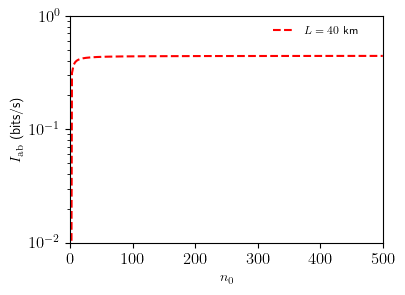

In [ ]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(4.150, 3.05))
ax.plot(n0_values, mutlistd40, color="red", ls='--', label=r'$L=40$ km')
ax.set_xlabel(r'$n_0$', fontsize=10)
ax.set_ylabel(r'$I_{\mathrm{ab}}$ (bits/s)', fontsize=10)
#ax.set_xscale('log')
ax.set_xlim(0,500)
ax.set_ylim(1e-2,1e0)
ax.set_yscale('log')

ax.legend(loc='upper right', fontsize=8, frameon=False, bbox_to_anchor=(0.955, 1))

fig.tight_layout()
plt.savefig('Fig_mutinfo_vs_n0.pdf', format='pdf', bbox_inches='tight', pad_inches=0.02, dpi=600)
plt.show()


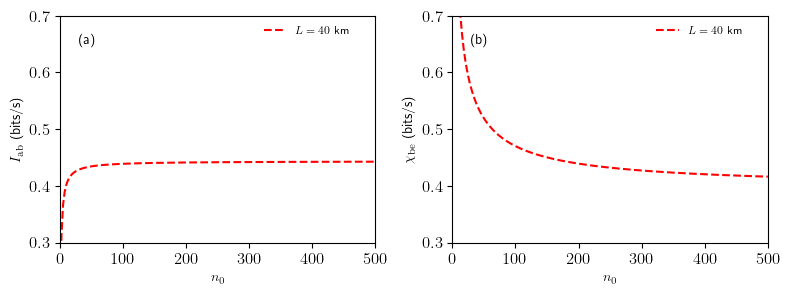

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 3.05))  # 2 subplots side by side

# --- Subplot (a): Mutual Information ---
axes[0].plot(n0_values, mutlistd40, color="red", ls='--', label=r'$L=40$ km')
axes[0].set_xlabel(r'$n_0$', fontsize=10)
axes[0].set_ylabel(r'$I_{\mathrm{ab}}$ (bits/s)', fontsize=10)
axes[0].set_xlim(0, 500)
axes[0].set_ylim(0.3,0.7)
#axes[0].set_yscale('log')
axes[0].legend(loc='upper right', fontsize=8, frameon=False, bbox_to_anchor=(0.95, 1))
axes[0].text(30, 0.65, r'(a)')

# --- Subplot (b): Holevo Bound ---
axes[1].plot(n0_values, hollistd40, color="red", ls='--', label=r'$L=40$ km')
axes[1].set_xlabel(r'$n_0$', fontsize=10)
axes[1].set_ylabel(r'$\chi_{\mathrm{be}}$ (bits/s)', fontsize=10)
axes[1].set_xlim(0, 500)
axes[1].set_ylim(0.3,0.7)
#axes[1].set_yscale('log')
axes[1].legend(loc='upper right', fontsize=8, frameon=False, bbox_to_anchor=(0.95, 1))
axes[1].text(30, 0.65, r'(b)')

# Adjust layout
fig.tight_layout()
plt.savefig('fig3.pdf', format='pdf', bbox_inches='tight', pad_inches=0.02, dpi=600)
plt.show()


In [ ]:
def secure_key_rate_f(VA,L,n0, f):
    T = 10 ** (-gamma * L / 10)
    e_A = 2 * VA * (1 + upsilon_el - (eta_D) / 2) / (n0 * eta_D)
    V = VA + 1
    epsilon_E = epsilon_0 + e_A
    chi_het = (1 + (1 - eta_D) + 2 * upsilon_el) / eta_D  # depends only on Bob's efficiency
    chi_line = (1 / T) - 1 + epsilon_E
    chi_tot = chi_line + chi_het / T

    # Ensure positive inputs for np.log2
    if V + chi_tot <= 0 or 1 + chi_tot <= 0:
        return float('-inf')

    I_AB = np.log2((V + chi_tot) / (1 + chi_tot))

    A = V**2 * (1 - 2*T) + 2*T + T**2 * (V + chi_line)**2
    B = T**2 * (V * chi_line + 1)**2

    A2_minus_4B = A**2 - 4 * B
    # Ensure non-negative input for np.sqrt
    if A2_minus_4B < 0:
        return float('-inf')

    lambda_1 =np.sqrt(0.5 * (A + np.sqrt(A2_minus_4B)))
    lambda_2 = np.sqrt(0.5 * (A - np.sqrt(A2_minus_4B)))
    C = (1 / (T * (V + chi_tot)))**2 * (A * chi_het**2 + B + 1 + 2 * chi_het * (V * np.sqrt(B) + T * (V + chi_line)) + 2 * T * (V**2 - 1))
    D = ((V + np.sqrt(B) * chi_het) / (T * (V + chi_tot)))**2
    C2_minus_4D = C**2 - 4 * D

    # Ensure non-negative input for np.sqrt
    if C2_minus_4D < 0:
        return float('-inf')
    lambda_3 = np.sqrt(0.5 * (C + np.sqrt(C2_minus_4D)))
    lambda_4 = np.sqrt(0.5 * (C - np.sqrt(C2_minus_4D)))
    lambda_5 = 1

    #G = lambda x: (x + 1) * np.log2(x + 1) - x * np.log2(x) if x >= 0 else float('-inf')

    # Ensure valid values for G function inputs
    g1 = G((lambda_1 - 1)/2)
    g2 = G((lambda_2 - 1)/2)
    g3 = G((lambda_3 - 1)/2)
    g4 = G((lambda_4 - 1)/2)
    g5 = G((lambda_5 - 1)/2)

    if g1 == float('-inf') or g2 == float('-inf') or g3 == float('-inf') or g4 == float('-inf') or g5 == float('-inf'):
        return float('-inf')

    chi_BE = g1 + g2 - g3 - g4 - g5

    if np.isnan(chi_BE):
        return float('-inf')


    R = f * I_AB - chi_BE


    return R


In [ ]:
def objective_f(VA,L,n0,f):
    R = -secure_key_rate_f(VA, L, n0,f)
    return R

In [ ]:
def optimal_va_f(L,n0,f):
    VA_bounds = (0.1, 10)
    result = minimize_scalar(lambda VA: objective_f(VA,L, n0,f),
                             bounds=VA_bounds, method='bounded')
    VA_opt = result.x
    return VA_opt

In [ ]:
def optkeyrate_f(L, n0,f):
    # Find the optimal VA
    VA_opt = optimal_va_f(L, n0,f)
    # Calculate the maximum key rate at this VA
    R_max = secure_key_rate_f(VA_opt, L, n0,f)
    return R_max

In [ ]:
L_values = np.linspace(0.1, 200, 500)
keylistp5=[]
keylistp6=[]
keylistp8=[]
keylist1=[]
for L in L_values:
  anspt5=optkeyrate_f(L, 100, 0.7)
  anspt6=optkeyrate_f(L, 100, 0.8)
  anspt8=optkeyrate_f(L, 100, 0.9)
  ans1=optkeyrate_f(L, 100,1)
  keylistp5.append(anspt5)
  keylistp6.append(anspt6)
  keylistp8.append(anspt8)
  keylist1.append(ans1)

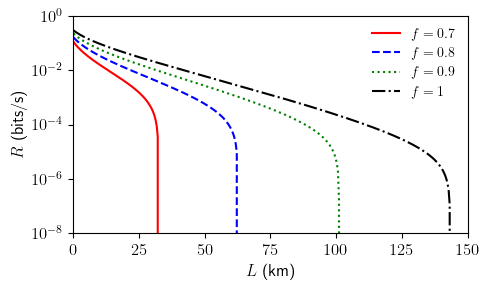

In [ ]:
# Create a single plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Plot key rate vs L for different detector efficiencies
ax.plot(L_values, keylistp5, color="red", ls='-', label=r'$f=0.7$')
ax.plot(L_values, keylistp6, color="blue", ls='--', label=r'$f=0.8$')
ax.plot(L_values, keylistp8, color="green", ls=':', label=r'$f=0.9$')
ax.plot(L_values, keylist1, color="black", ls='-.', label=r'$f=1$')

# Set log scale for y-axis
ax.set_yscale('log')

# Labels and ticks
ax.set_xlabel(r'$L$ (km)', fontsize=12)
ax.set_ylabel(r'$R$ (bits/s)', fontsize=12)
ax.set_xlim(0, 150)
ax.set_ylim(1e-8, 1e0)

# Legend
ax.legend(fontsize=10, loc='upper right', frameon=False)

# Layout adjustment
fig.tight_layout()

# Save the figure
plt.savefig('fig5.pdf', format='pdf', bbox_inches='tight', dpi=600)

plt.show()


In [ ]:
def secure_key_rate_e0(VA,L,n0, epsilon_0):
    T = 10 ** (-gamma * L / 10)
    e_A = 2 * VA * (1 + upsilon_el - (eta_D) / 2) / (n0 * eta_D)
    V = VA + 1
    epsilon_E = epsilon_0 + e_A
    chi_het = (1 + (1 - eta_D) + 2 * upsilon_el) / eta_D  # depends only on Bob's efficiency
    chi_line = (1 / T) - 1 + epsilon_E
    chi_tot = chi_line + chi_het / T

    # Ensure positive inputs for np.log2
    if V + chi_tot <= 0 or 1 + chi_tot <= 0:
        return float('-inf')

    I_AB = np.log2((V + chi_tot) / (1 + chi_tot))

    A = V**2 * (1 - 2*T) + 2*T + T**2 * (V + chi_line)**2
    B = T**2 * (V * chi_line + 1)**2

    A2_minus_4B = A**2 - 4 * B
    # Ensure non-negative input for np.sqrt
    if A2_minus_4B < 0:
        return float('-inf')

    lambda_1 =np.sqrt(0.5 * (A + np.sqrt(A2_minus_4B)))
    lambda_2 = np.sqrt(0.5 * (A - np.sqrt(A2_minus_4B)))
    C = (1 / (T * (V + chi_tot)))**2 * (A * chi_het**2 + B + 1 + 2 * chi_het * (V * np.sqrt(B) + T * (V + chi_line)) + 2 * T * (V**2 - 1))
    D = ((V + np.sqrt(B) * chi_het) / (T * (V + chi_tot)))**2
    C2_minus_4D = C**2 - 4 * D

    # Ensure non-negative input for np.sqrt
    if C2_minus_4D < 0:
        return float('-inf')
    lambda_3 = np.sqrt(0.5 * (C + np.sqrt(C2_minus_4D)))
    lambda_4 = np.sqrt(0.5 * (C - np.sqrt(C2_minus_4D)))
    lambda_5 = 1

    #G = lambda x: (x + 1) * np.log2(x + 1) - x * np.log2(x) if x >= 0 else float('-inf')

    # Ensure valid values for G function inputs
    g1 = G((lambda_1 - 1)/2)
    g2 = G((lambda_2 - 1)/2)
    g3 = G((lambda_3 - 1)/2)
    g4 = G((lambda_4 - 1)/2)
    g5 = G((lambda_5 - 1)/2)

    if g1 == float('-inf') or g2 == float('-inf') or g3 == float('-inf') or g4 == float('-inf') or g5 == float('-inf'):
        return float('-inf')

    chi_BE = g1 + g2 - g3 - g4 - g5

    if np.isnan(chi_BE):
        return float('-inf')


    R = f * I_AB - chi_BE

    return R


In [ ]:
def objective_e0(VA,L,n0,e0):
    R = -secure_key_rate_e0(VA, L, n0,e0)
    return R

In [ ]:
def optimal_va_e0(L,n0,e0):
    VA_bounds = (0.1, 10)
    result = minimize_scalar(lambda VA: objective_e0(VA,L, n0,e0),
                             bounds=VA_bounds, method='bounded')
    VA_opt = result.x
    return VA_opt

In [ ]:
def optkeyrate_e0(L, n0,e0):
    # Find the optimal VA
    VA_opt = optimal_va_e0(L, n0,e0)
    # Calculate the maximum key rate at this VA
    R_max = secure_key_rate_e0(VA_opt, L, n0,e0)
    return R_max

In [ ]:
L_values = np.linspace(0.1, 200, 500)
keyliste01=[]
keyliste02=[]
keyliste03=[]
keyliste04=[]
for L in L_values:
  anspt5=optkeyrate_e0(L, 100, 0.007)
  anspt6=optkeyrate_e0(L, 100, 0.008)
  anspt8=optkeyrate_e0(L, 100, 0.009)
  ans1=optkeyrate_e0(L, 100,0.01)
  keyliste01.append(anspt5)
  keyliste02.append(anspt6)
  keyliste03.append(anspt8)
  keyliste04.append(ans1)

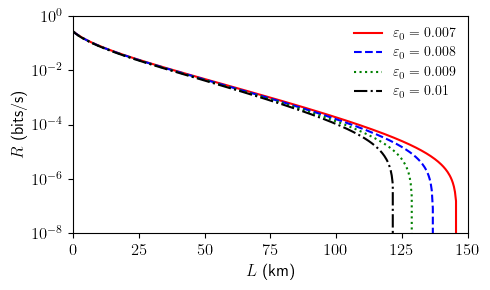

In [ ]:
# Create a single plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Plot key rate vs L for different detector efficiencies
ax.plot(L_values, keyliste01, color="red", ls='-', label=r'$\varepsilon_0=0.007$')
ax.plot(L_values, keyliste02, color="blue", ls='--', label=r'$\varepsilon_0=0.008$')
ax.plot(L_values, keyliste03, color="green", ls=':', label=r'$\varepsilon_0=0.009$')
ax.plot(L_values, keyliste04, color="black", ls='-.', label=r'$\varepsilon_0=0.01$')

# Set log scale for y-axis
ax.set_yscale('log')

# Labels and ticks
ax.set_xlabel(r'$L$ (km)', fontsize=12)
ax.set_ylabel(r'$R$ (bits/s)', fontsize=12)
ax.set_xlim(0, 150)
ax.set_ylim(1e-8, 1e0)

# Legend
ax.legend(fontsize=10, loc='upper right', frameon=False)

# Layout adjustment
fig.tight_layout()

# Save the figure
plt.savefig('fig4.pdf', format='pdf', bbox_inches='tight', dpi=600)

plt.show()
